In [1]:
import os

# Base data folder
base_path = 'C:\\Users\\aamir\\Downloads\\umc005-corpus'

# Subfolders
folders = ['quran', 'bible']

# File names
files = ['train.en', 'train.ur', 'test.en', 'test.ur', 'dev.en', 'dev.ur']

# Dictionary to store the data
data = {}

# Loop through each folder and file
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    data[folder] = {}
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            data[folder][file_name] = content
        else:
            print(f"Warning: {file_path} not found.")

# Example: accessing Quran's training English data
print(data['quran']['train.en'][:500])  # Print first 500 characters
print(data['quran']['train.ur'][:500])  
print(data['bible']['train.en'][:500])  # Print first 500 characters
print(data['quran']['train.ur'][:500])  # Print first 500 characters


All praise be to Allah alone , the Sustainer of all the worlds .
Most Compassionate , Ever - Merciful .
Master of the Day of Judgment .
( O Allah ! ) You alone do we worship and to You alone we look for help .
Show us the straight path .
The path of those upon whom You have bestowed Your favours .
Not of those who have been afflicted with wrath and nor of those who have gone astray .
Alif , Lam , Mim . ( Only Allah and the Messenger know the real meaning . )
( This is ) the Glorious Book in whi
﻿سب تعریفیں اللہ ہی کے لئے ہیں جو تمام جہانوں کی پرورش فرمانے والا ہے ۔
نہایت مہربان بہت رحم فرمانے والا ہے ۔
روز جزا کا مالک ہے ۔
اے اللہ ! ہم تیری ہی عبادت کرتے ہیں اور ہم تجھ ہی سے مدد چاہتے ہیں ۔
ہمیں سیدھا راستہ دکھا ۔
ان لوگوں کا راستہ جن پر تو نے انعام فرمایا ۔
ان لوگوں کا نہیں جن پر غضب کیا گیا ہے اور نہ ہی گمراہوں کا ۔
الف لام میم حقیقی معنی اﷲ اور رسول صلی اللہ علیہ وآلہ وسلم ہی بہتر جانتے ہیں ۔
یہ وہ عظیم کتاب ہے جس میں کسی شک کی گنجائش نہیں ، یہ پرہیزگاروں کے لئے ہدایت ہے ۔
جو غیب پر

In [2]:
import os
import sentencepiece as spm

# Base data folder
base_path = 'C:\\Users\\aamir\\Downloads\\umc005-corpus'
folders = ['quran', 'bible']
files = ['train.en', 'train.ur', 'test.en', 'test.ur', 'dev.en', 'dev.ur']

# Dictionary to store the data
data = {}

# Reading and cleaning function
def clean_text(text):
    text = text.strip()  # Remove leading/trailing spaces
    text = text.replace('\u200c', '')  # Remove zero-width non-joiner (Urdu issue)
    text = text.replace('\n', ' ')  # Replace newlines with space
    text = ' '.join(text.split())  # Remove extra spaces
    return text

# Load all files
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    data[folder] = {}
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            lines = [clean_text(line) for line in lines]
            data[folder][file_name] = lines
        else:
            print(f"Warning: {file_path} not found.")

# Write temporary files for BPE training
os.makedirs('temp', exist_ok=True)
for lang in ['en', 'ur']:
    combined_data = []
    for folder in folders:
        for split in ['train', 'test', 'dev']:
            combined_data += data[folder][f'{split}.{lang}']
    with open(f'temp/combined_{lang}.txt', 'w', encoding='utf-8') as f:
        for line in combined_data:
            f.write(line + '\n')


# Train BPE model (one for English, one for Urdu) - vocab size adjusted!
def get_vocab_limit(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    unique_chars = set(''.join(lines))   # Approximation (characters/subwords)
    return max(1000, int(len(unique_chars) * 2))  # Simple logic: 2x unique chars

vocab_size_en = min(5000, get_vocab_limit('temp/combined_en.txt'))
vocab_size_ur = min(4500, get_vocab_limit('temp/combined_ur.txt'))

spm.SentencePieceTrainer.train(input='temp/combined_en.txt', model_prefix='bpe_en', vocab_size=vocab_size_en)
spm.SentencePieceTrainer.train(input='temp/combined_ur.txt', model_prefix='bpe_ur', vocab_size=vocab_size_ur)


# Load trained tokenizers
tokenizer_en = spm.SentencePieceProcessor(model_file='bpe_en.model')
tokenizer_ur = spm.SentencePieceProcessor(model_file='bpe_ur.model')

# Tokenize the dataset
tokenized_data = {}

for folder in folders:
    tokenized_data[folder] = {}
    for split in ['train', 'test', 'dev']:
        en_lines = data[folder][f'{split}.en']
        ur_lines = data[folder][f'{split}.ur']
        
        # Ensure alignment
        assert len(en_lines) == len(ur_lines), f"Mismatch in {folder}/{split}"
        
        tokenized_en = [tokenizer_en.encode(line, out_type=str) for line in en_lines]
        tokenized_ur = [tokenizer_ur.encode(line, out_type=str) for line in ur_lines]
        
        tokenized_data[folder][f'{split}.en'] = tokenized_en
        tokenized_data[folder][f'{split}.ur'] = tokenized_ur

# Example: print first tokenized sentence
print("Tokenized Quran English Example:", tokenized_data['quran']['train.en'][0])
print("Tokenized Quran Urdu Example:", tokenized_data['quran']['train.ur'][0])
print("Tokenized Bible English Example:", tokenized_data['bible']['train.en'][0])
print("Tokenized Bible Urdu Example:", tokenized_data['bible']['train.ur'][0])


Tokenized Quran English Example: ['▁All', '▁praise', '▁be', '▁to', '▁Allah', '▁a', 'lone', '▁,', '▁the', '▁S', 'us', 't', 'ain', 'er', '▁of', '▁all', '▁the', '▁world', 's', '▁.']
Tokenized Quran Urdu Example: ['▁سب', '▁تعریف', 'یں', '▁ال', 'لہ', '▁ہی', '▁کے', '▁ل', 'ئے', '▁ہیں', '▁جو', '▁تم', 'ام', '▁جہان', 'وں', '▁کی', '▁پر', 'ور', 'ش', '▁فرما', 'نے', '▁والا', '▁ہے', '▁۔']
Tokenized Bible English Example: ['▁The', '▁bo', 'ok', '▁of', '▁the', '▁generation', '▁of', '▁Jes', 'us', '▁Christ', '▁,', '▁the', '▁son', '▁of', '▁', 'D', 'avi', 'd', '▁,', '▁the', '▁son', '▁of', '▁Abraham', '▁.']
Tokenized Bible Urdu Example: ['▁یسو', 'ع', '▁مسیح', '▁اب', 'ن', '▁د', 'ا', 'ود', '▁اب', 'ن', '▁اب', 'ر', 'ہ', 'ام', '▁کا', '▁نسب', '▁نام', 'ہ']


Transformer


Epoch 1/15
  Batch 1/210 - Loss: 7.1009
  Batch 2/210 - Loss: 6.8162
  Batch 3/210 - Loss: 6.6317
  Batch 4/210 - Loss: 6.5375
  Batch 5/210 - Loss: 6.4502
  Batch 6/210 - Loss: 6.3997
  Batch 7/210 - Loss: 6.3508
  Batch 8/210 - Loss: 6.3275
  Batch 9/210 - Loss: 6.2932
  Batch 10/210 - Loss: 6.2760
  Batch 11/210 - Loss: 6.2782
  Batch 12/210 - Loss: 6.2384
  Batch 13/210 - Loss: 6.2619
  Batch 14/210 - Loss: 6.2240
  Batch 15/210 - Loss: 6.1458
  Batch 16/210 - Loss: 6.1652
  Batch 17/210 - Loss: 6.1257
  Batch 18/210 - Loss: 6.1259
  Batch 19/210 - Loss: 6.1302
  Batch 20/210 - Loss: 6.0971
  Batch 21/210 - Loss: 6.0919
  Batch 22/210 - Loss: 6.0332
  Batch 23/210 - Loss: 6.0520
  Batch 24/210 - Loss: 6.0212
  Batch 25/210 - Loss: 5.9839
  Batch 26/210 - Loss: 6.0013
  Batch 27/210 - Loss: 5.9597
  Batch 28/210 - Loss: 5.9726
  Batch 29/210 - Loss: 5.8964
  Batch 30/210 - Loss: 5.9275
  Batch 31/210 - Loss: 5.9127
  Batch 32/210 - Loss: 5.8933
  Batch 33/210 - Loss: 5.8966
  Batch

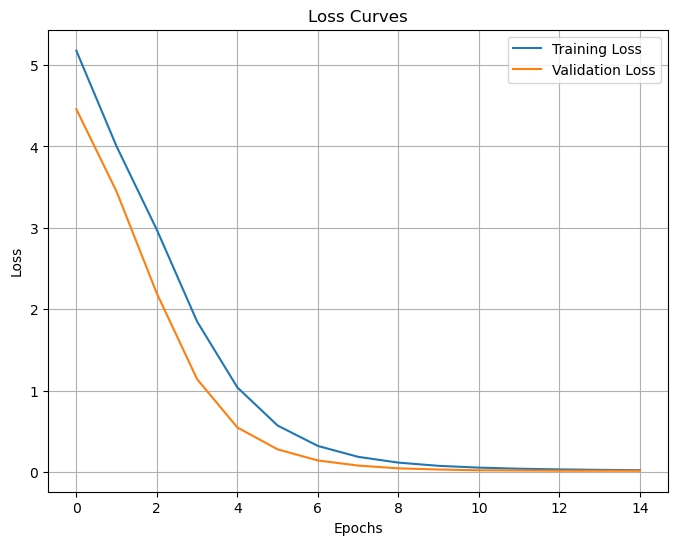

C:\Users\aamir\AppData\Local\Temp\ipykernel_18448\1437661571.py:218: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_transformer.pth'))


TypeError: Fraction.__new__() got an unexpected keyword argument '_normalize'

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import math
import numpy as np
import random
import sentencepiece as spm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =================== Dataset ===================

class TranslationDataset(Dataset):
    def __init__(self, source_lines, target_lines, src_tokenizer, tgt_tokenizer, max_len=100):
        self.source_lines = source_lines
        self.target_lines = target_lines
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.source_lines)
    
    def __getitem__(self, idx):
        src = self.source_lines[idx][:self.max_len]
        tgt = self.target_lines[idx][:self.max_len]
        
        src_ids = [self.src_tokenizer.piece_to_id(p) for p in src]
        tgt_ids = [self.tgt_tokenizer.piece_to_id(p) for p in tgt]
        
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

# =================== Positional Encoding ===================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# =================== Transformer Model ===================

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        
        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers,
                                          dim_feedforward, dropout, batch_first=True)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        output = self.transformer(src_emb, tgt_emb, src_key_padding_mask=src_mask, tgt_key_padding_mask=tgt_mask)
        return self.fc_out(output)

# =================== Utilities ===================

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_batch, tgt_batch

def compute_bleu(predictions, references):
    return corpus_bleu([[ref] for ref in references], predictions)

def compute_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1, rouge2, rougeL = [], [], []
    for pred, ref in zip(predictions, references):
        pred_sentence = " ".join(pred)
        ref_sentence = " ".join(ref)
        scores = scorer.score(ref_sentence, pred_sentence)
        rouge1.append(scores['rouge1'].fmeasure)
        rouge2.append(scores['rouge2'].fmeasure)
        rougeL.append(scores['rougeL'].fmeasure)
    return {
        "rouge-1": np.mean(rouge1),
        "rouge-2": np.mean(rouge2),
        "rouge-L": np.mean(rougeL)
    }

def plot_training(train_losses, val_losses):
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# =================== Training Function ===================

def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=30, patience=5):
    best_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            optimizer.zero_grad()
            output = model(src, tgt_input)
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(output, tgt_output)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")
        
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1} Completed. Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        scheduler.step(avg_val_loss)  # No 'verbose' here
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_transformer.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping triggered!')
                break
    
    plot_training(train_losses, val_losses)

def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            output = model(src, tgt_input)
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# =================== Main Execution ===================

train_src = tokenized_data['quran']['train.en'] + tokenized_data['bible']['train.en']
train_tgt = tokenized_data['quran']['train.ur'] + tokenized_data['bible']['train.ur']

val_src = tokenized_data['quran']['dev.en'] + tokenized_data['bible']['dev.en']
val_tgt = tokenized_data['quran']['dev.ur'] + tokenized_data['bible']['dev.ur']

test_src = tokenized_data['quran']['test.en'] + tokenized_data['bible']['test.en']
test_tgt = tokenized_data['quran']['test.ur'] + tokenized_data['bible']['test.ur']

train_dataset = TranslationDataset(train_src, train_tgt, tokenizer_en, tokenizer_ur)
val_dataset = TranslationDataset(val_src, val_tgt, tokenizer_en, tokenizer_ur)
test_dataset = TranslationDataset(test_src, test_tgt, tokenizer_en, tokenizer_ur)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

SRC_VOCAB_SIZE = len(tokenizer_en)
TGT_VOCAB_SIZE = len(tokenizer_ur)

model = Transformer(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, d_model=256, nhead=4, num_encoder_layers=3, num_decoder_layers=3).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Train
train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=15, patience=5)

# Load best model
model.load_state_dict(torch.load('best_transformer.pth'))
model.eval()

predictions, references = [], []

with torch.no_grad():
    for src, tgt in test_loader:
        src = src.to(device)
        tgt_input = torch.zeros_like(src[:, :1]).fill_(2)  # Assuming 2 = <BOS> token id
        outputs = []
        
        for _ in range(50):
            output = model(src, tgt_input)
            next_token = output[:, -1, :].argmax(-1, keepdim=True)
            tgt_input = torch.cat([tgt_input, next_token], dim=1)
            outputs.append(next_token)
        
        outputs = torch.cat(outputs, dim=1)
        pred_tokens = [tokenizer_ur.id_to_piece(int(tok)) for tok in outputs[0]]
        tgt_tokens = [tokenizer_ur.id_to_piece(int(tok)) for tok in tgt[0]]
        
        predictions.append(pred_tokens)
        references.append(tgt_tokens)

# Compute and display BLEU & ROUGE
bleu = compute_bleu(predictions, references)
rouge = compute_rouge(predictions, references)

print(f'\nBLEU Score: {bleu:.4f}')
print('ROUGE Scores:', rouge)

# Visualization
labels = list(rouge.keys())
scores = list(rouge.values())

plt.figure(figsize=(7,5))
plt.bar(labels, scores, color='skyblue')
plt.title('ROUGE Scores')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()



Epoch 1/13
  Batch 1/210 - Loss: 7.1009
  Batch 2/210 - Loss: 6.8162
  Batch 3/210 - Loss: 6.6317
  Batch 4/210 - Loss: 6.5375
  Batch 5/210 - Loss: 6.4502
  Batch 6/210 - Loss: 6.3997
  Batch 7/210 - Loss: 6.3508
  Batch 8/210 - Loss: 6.3275
  Batch 9/210 - Loss: 6.2932
  Batch 10/210 - Loss: 6.2760
  Batch 11/210 - Loss: 6.2782
  Batch 12/210 - Loss: 6.2384
  Batch 13/210 - Loss: 6.2619
  Batch 14/210 - Loss: 6.2240
  Batch 15/210 - Loss: 6.1458
  Batch 16/210 - Loss: 6.1652
  Batch 17/210 - Loss: 6.1257
  Batch 18/210 - Loss: 6.1259
  Batch 19/210 - Loss: 6.1302
  Batch 20/210 - Loss: 6.0971
  Batch 21/210 - Loss: 6.0919
  Batch 22/210 - Loss: 6.0332
  Batch 23/210 - Loss: 6.0520
  Batch 24/210 - Loss: 6.0212
  Batch 25/210 - Loss: 5.9839
  Batch 26/210 - Loss: 6.0013
  Batch 27/210 - Loss: 5.9597
  Batch 28/210 - Loss: 5.9726
  Batch 29/210 - Loss: 5.8964
  Batch 30/210 - Loss: 5.9275
  Batch 31/210 - Loss: 5.9127
  Batch 32/210 - Loss: 5.8933
  Batch 33/210 - Loss: 5.8966
  Batch

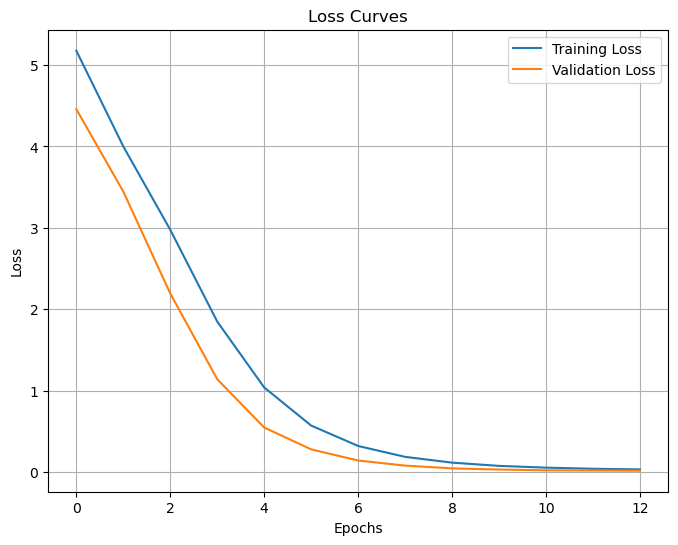


BLEU Score: 0.0000
ROUGE Scores: {'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-L': 0.0}


C:\Users\aamir\AppData\Roaming\Python\Python312\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\aamir\AppData\Roaming\Python\Python312\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\aamir\AppData\Roaming\Python\Python312\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider usi

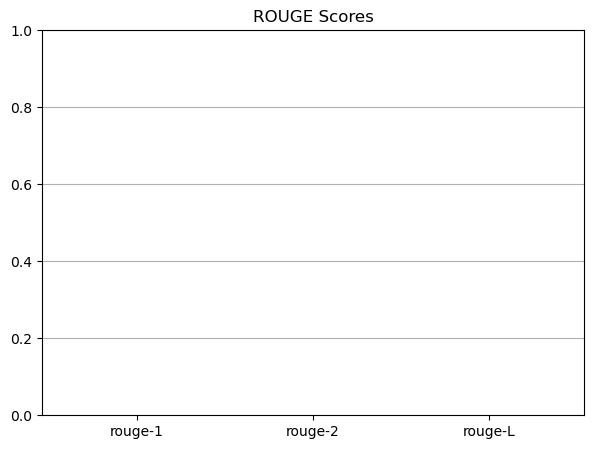

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import math
import numpy as np
import random
import sentencepiece as spm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =================== Dataset ===================

class TranslationDataset(Dataset):
    def __init__(self, source_lines, target_lines, src_tokenizer, tgt_tokenizer, max_len=100):
        self.source_lines = source_lines
        self.target_lines = target_lines
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.source_lines)
    
    def __getitem__(self, idx):
        src = self.source_lines[idx][:self.max_len]
        tgt = self.target_lines[idx][:self.max_len]
        
        src_ids = [self.src_tokenizer.piece_to_id(p) for p in src]
        tgt_ids = [self.tgt_tokenizer.piece_to_id(p) for p in tgt]
        
        return torch.tensor(src_ids), torch.tensor(tgt_ids)

# =================== Positional Encoding ===================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# =================== Transformer Model ===================

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        
        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers,
                                          dim_feedforward, dropout, batch_first=True)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        
    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        output = self.transformer(src_emb, tgt_emb, src_key_padding_mask=src_mask, tgt_key_padding_mask=tgt_mask)
        return self.fc_out(output)

# =================== Utilities ===================

def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = nn.utils.rnn.pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_batch, tgt_batch

def compute_bleu(predictions, references):
    return corpus_bleu([[ref] for ref in references], predictions)

def compute_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1, rouge2, rougeL = [], [], []
    for pred, ref in zip(predictions, references):
        pred_sentence = " ".join(pred)
        ref_sentence = " ".join(ref)
        scores = scorer.score(ref_sentence, pred_sentence)
        rouge1.append(scores['rouge1'].fmeasure)
        rouge2.append(scores['rouge2'].fmeasure)
        rougeL.append(scores['rougeL'].fmeasure)
    return {
        "rouge-1": np.mean(rouge1),
        "rouge-2": np.mean(rouge2),
        "rouge-L": np.mean(rougeL)
    }

def plot_training(train_losses, val_losses):
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# =================== Training Function ===================

def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=30, patience=5):
    best_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            optimizer.zero_grad()
            output = model(src, tgt_input)
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(output, tgt_output)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")
        
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1} Completed. Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        scheduler.step(avg_val_loss)  # No 'verbose' here
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_transformer.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping triggered!')
                break
    
    plot_training(train_losses, val_losses)

def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            output = model(src, tgt_input)
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# =================== Main Execution ===================

train_src = tokenized_data['quran']['train.en'] + tokenized_data['bible']['train.en']
train_tgt = tokenized_data['quran']['train.ur'] + tokenized_data['bible']['train.ur']

val_src = tokenized_data['quran']['dev.en'] + tokenized_data['bible']['dev.en']
val_tgt = tokenized_data['quran']['dev.ur'] + tokenized_data['bible']['dev.ur']

test_src = tokenized_data['quran']['test.en'] + tokenized_data['bible']['test.en']
test_tgt = tokenized_data['quran']['test.ur'] + tokenized_data['bible']['test.ur']

train_dataset = TranslationDataset(train_src, train_tgt, tokenizer_en, tokenizer_ur)
val_dataset = TranslationDataset(val_src, val_tgt, tokenizer_en, tokenizer_ur)
test_dataset = TranslationDataset(test_src, test_tgt, tokenizer_en, tokenizer_ur)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

SRC_VOCAB_SIZE = len(tokenizer_en)
TGT_VOCAB_SIZE = len(tokenizer_ur)

model = Transformer(SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, d_model=256, nhead=4, num_encoder_layers=3, num_decoder_layers=3).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Train
train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=13, patience=5)

# Load best model
model.load_state_dict(torch.load('best_transformer.pth', weights_only=True))
model.eval()

predictions, references = [], []

with torch.no_grad():
    for src, tgt in test_loader:
        src = src.to(device)
        tgt_input = torch.zeros_like(src[:, :1]).fill_(2)  # Assuming 2 = <BOS> token id
        outputs = []
        
        for _ in range(50):
            output = model(src, tgt_input)
            next_token = output[:, -1, :].argmax(-1, keepdim=True)
            tgt_input = torch.cat([tgt_input, next_token], dim=1)
            outputs.append(next_token)
        
        outputs = torch.cat(outputs, dim=1)
        pred_tokens = [tokenizer_ur.id_to_piece(int(tok)) for tok in outputs[0]]
        tgt_tokens = [tokenizer_ur.id_to_piece(int(tok)) for tok in tgt[0]]
        
        predictions.append(pred_tokens)
        references.append(tgt_tokens)

# Compute and display BLEU & ROUGE
bleu = compute_bleu(predictions, references)
rouge = compute_rouge(predictions, references)

print(f'\nBLEU Score: {bleu:.4f}')
print('ROUGE Scores:', rouge)

# Visualization
labels = list(rouge.keys())
scores = list(rouge.values())

plt.figure(figsize=(7,5))
plt.bar(labels, scores, color='skyblue')
plt.title('ROUGE Scores')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()




Epoch 1 Starting...
Epoch 1 | Batch 1/94 | Batch Loss: 7.0999
Epoch 1 | Batch 2/94 | Batch Loss: 6.9020
Epoch 1 | Batch 3/94 | Batch Loss: 6.7452
Epoch 1 | Batch 4/94 | Batch Loss: 6.6455
Epoch 1 | Batch 5/94 | Batch Loss: 6.5910
Epoch 1 | Batch 6/94 | Batch Loss: 6.5154
Epoch 1 | Batch 7/94 | Batch Loss: 6.4910
Epoch 1 | Batch 8/94 | Batch Loss: 6.4353
Epoch 1 | Batch 9/94 | Batch Loss: 6.3976
Epoch 1 | Batch 10/94 | Batch Loss: 6.3651
Epoch 1 | Batch 11/94 | Batch Loss: 6.3423
Epoch 1 | Batch 12/94 | Batch Loss: 6.2756
Epoch 1 | Batch 13/94 | Batch Loss: 6.2545
Epoch 1 | Batch 14/94 | Batch Loss: 6.2579
Epoch 1 | Batch 15/94 | Batch Loss: 6.2252
Epoch 1 | Batch 16/94 | Batch Loss: 6.2190
Epoch 1 | Batch 17/94 | Batch Loss: 6.2131
Epoch 1 | Batch 18/94 | Batch Loss: 6.1826
Epoch 1 | Batch 19/94 | Batch Loss: 6.1568
Epoch 1 | Batch 20/94 | Batch Loss: 6.1516
Epoch 1 | Batch 21/94 | Batch Loss: 6.1184
Epoch 1 | Batch 22/94 | Batch Loss: 6.1026
Epoch 1 | Batch 23/94 | Batch Loss: 6.0939

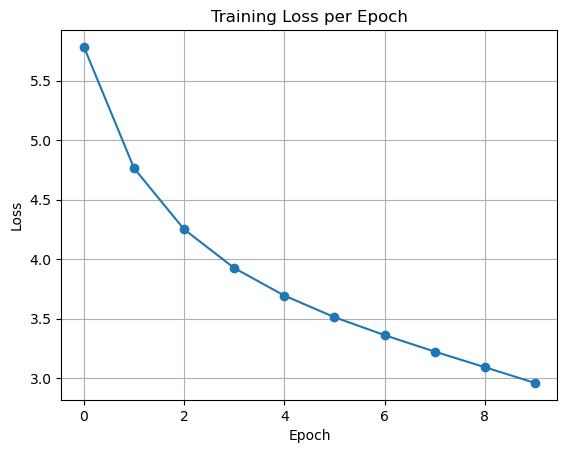

C:\Users\aamir\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(



BLEU Score: 1.86
ROUGE-1: 0.00
ROUGE-2: 0.00
ROUGE-L: 0.00


In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# ========== 1. Load Tokenizers ==========

tokenizer_en = spm.SentencePieceProcessor(model_file='bpe_en.model')
tokenizer_ur = spm.SentencePieceProcessor(model_file='bpe_ur.model')

# ========== 2. Dataset ==========

class TranslationDataset(Dataset):
    def __init__(self, src_lines, tgt_lines, src_tokenizer, tgt_tokenizer, max_len=128):
        self.src_lines = src_lines
        self.tgt_lines = tgt_lines
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        src = [self.src_tokenizer.bos_id()] + self.src_tokenizer.encode(self.src_lines[idx], out_type=int) + [self.src_tokenizer.eos_id()]
        tgt = [self.tgt_tokenizer.bos_id()] + self.tgt_tokenizer.encode(self.tgt_lines[idx], out_type=int) + [self.tgt_tokenizer.eos_id()]
        
        src = src[:self.max_len] + [0]*(self.max_len - len(src)) if len(src) < self.max_len else src[:self.max_len]
        tgt = tgt[:self.max_len] + [0]*(self.max_len - len(tgt)) if len(tgt) < self.max_len else tgt[:self.max_len]
        
        return torch.tensor(src), torch.tensor(tgt)

# ========== 3. Transformer Model ==========

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8, num_layers=4, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.rand(5000, d_model), requires_grad=True)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,  # important
        )

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt):
        src_emb = self.src_tok_emb(src) + self.positional_encoding[:src.size(1)]
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding[:tgt.size(1)]
        
        src_padding_mask = (src == 0)
        tgt_padding_mask = (tgt == 0)
        
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(src.device)

        # ⚡ Fix here: Make types same
        tgt_mask = tgt_mask.masked_fill(tgt_mask == float('-inf'), True).masked_fill(tgt_mask == 0, False)

        output = self.transformer(
            src_emb, tgt_emb,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
            tgt_mask=tgt_mask,
        )
        output = self.fc_out(output)
        return output

# ========== 4. Prepare Dataset ==========

train_src = data['quran']['train.en']
train_tgt = data['quran']['train.ur']
test_src = data['quran']['test.en']
test_tgt = data['quran']['test.ur']

train_dataset = TranslationDataset(train_src, train_tgt, tokenizer_en, tokenizer_ur)
test_dataset = TranslationDataset(test_src, test_tgt, tokenizer_en, tokenizer_ur)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# ========== 5. Train ==========

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerModel(
    tokenizer_en.get_piece_size(),
    tokenizer_ur.get_piece_size()
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)

train_losses = []

for epoch in range(10):  # Number of epochs
    model.train()
    running_loss = 0.0
    print(f"\nEpoch {epoch+1} Starting...")
    for batch_idx, (src, tgt) in enumerate(train_loader):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.reshape(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 🛠 Print batch loss
        print(f"Epoch {epoch+1} | Batch {batch_idx+1}/{len(train_loader)} | Batch Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Finished | Average Loss: {avg_loss:.4f}")

# ========== 6. Visualize Loss ==========

plt.plot(train_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# ========== 7. Evaluate BLEU and ROUGE ==========

model.eval()
refs = []
hyps = []

with torch.no_grad():
    for src, tgt in test_loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]

        output = model(src, tgt_input)
        output = output.argmax(dim=-1)

        for i in range(output.size(0)):
            pred_tokens = output[i].cpu().numpy().tolist()
            true_tokens = tgt[i, 1:].cpu().numpy().tolist()

            pred_sentence = tokenizer_ur.decode([tok for tok in pred_tokens if tok > 0])
            true_sentence = tokenizer_ur.decode([tok for tok in true_tokens if tok > 0])

            hyps.append(pred_sentence.split())
            refs.append([true_sentence.split()])

smoothie = SmoothingFunction().method4
bleu_score = corpus_bleu(refs, hyps, smoothing_function=smoothie)
print(f"\nBLEU Score: {bleu_score*100:.2f}")

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1, rouge2, rougel = [], [], []

for r, h in zip(refs, hyps):
    scores = scorer.score(' '.join(r[0]), ' '.join(h))
    rouge1.append(scores['rouge1'].fmeasure)
    rouge2.append(scores['rouge2'].fmeasure)
    rougel.append(scores['rougeL'].fmeasure)

print(f"ROUGE-1: {np.mean(rouge1)*100:.2f}")
print(f"ROUGE-2: {np.mean(rouge2)*100:.2f}")
print(f"ROUGE-L: {np.mean(rougel)*100:.2f}")



Epoch 1 Starting...
Epoch 1 | Batch 1/94 | Batch Loss: 7.0619
Epoch 1 | Batch 2/94 | Batch Loss: 6.8491
Epoch 1 | Batch 3/94 | Batch Loss: 6.7195
Epoch 1 | Batch 4/94 | Batch Loss: 6.6177
Epoch 1 | Batch 5/94 | Batch Loss: 6.5322
Epoch 1 | Batch 6/94 | Batch Loss: 6.5054
Epoch 1 | Batch 7/94 | Batch Loss: 6.4460
Epoch 1 | Batch 8/94 | Batch Loss: 6.4221
Epoch 1 | Batch 9/94 | Batch Loss: 6.3628
Epoch 1 | Batch 10/94 | Batch Loss: 6.3137
Epoch 1 | Batch 11/94 | Batch Loss: 6.2934
Epoch 1 | Batch 12/94 | Batch Loss: 6.2870
Epoch 1 | Batch 13/94 | Batch Loss: 6.2682
Epoch 1 | Batch 14/94 | Batch Loss: 6.2553
Epoch 1 | Batch 15/94 | Batch Loss: 6.2202
Epoch 1 | Batch 16/94 | Batch Loss: 6.1890
Epoch 1 | Batch 17/94 | Batch Loss: 6.1680
Epoch 1 | Batch 18/94 | Batch Loss: 6.1364
Epoch 1 | Batch 19/94 | Batch Loss: 6.1321
Epoch 1 | Batch 20/94 | Batch Loss: 6.1353
Epoch 1 | Batch 21/94 | Batch Loss: 6.1155
Epoch 1 | Batch 22/94 | Batch Loss: 6.0914
Epoch 1 | Batch 23/94 | Batch Loss: 6.0750

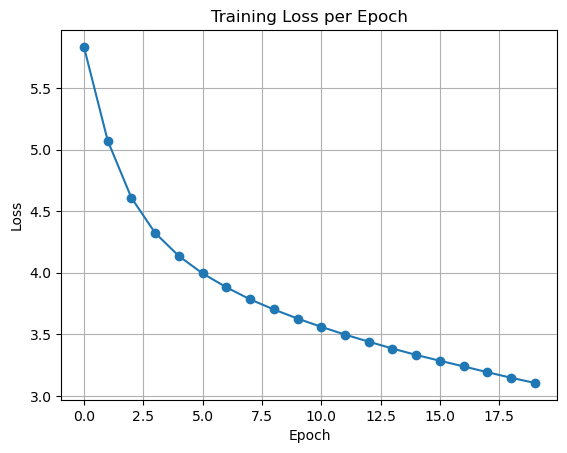


BLEU Score: 0.51
ROUGE-1: 0.00
ROUGE-2: 0.00
ROUGE-L: 0.00


In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# 1. Load Tokenizers
tokenizer_en = spm.SentencePieceProcessor(model_file='bpe_en.model')
tokenizer_ur = spm.SentencePieceProcessor(model_file='bpe_ur.model')

# 2. Dataset
class TranslationDataset(Dataset):
    def __init__(self, src_lines, tgt_lines, src_tokenizer, tgt_tokenizer, max_len=128):
        self.src_lines = src_lines
        self.tgt_lines = tgt_lines
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        src = [self.src_tokenizer.bos_id()] + self.src_tokenizer.encode(self.src_lines[idx], out_type=int) + [self.src_tokenizer.eos_id()]
        tgt = [self.tgt_tokenizer.bos_id()] + self.tgt_tokenizer.encode(self.tgt_lines[idx], out_type=int) + [self.tgt_tokenizer.eos_id()]
        
        src = src[:self.max_len]
        tgt = tgt[:self.max_len]

        src += [0] * (self.max_len - len(src))
        tgt += [0] * (self.max_len - len(tgt))
        
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

# 3. Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8, num_layers=4, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(5000, d_model), requires_grad=True)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True, # <-- Important to fix nested tensor warning
        )

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt):
        src_emb = self.src_tok_emb(src) + self.positional_encoding[:src.size(1)]
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding[:tgt.size(1)]

        src_padding_mask = (src == 0)
        tgt_padding_mask = (tgt == 0)

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(src.device)

        output = self.transformer(
            src_emb,
            tgt_emb,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
            tgt_mask=tgt_mask
        )

        output = self.fc_out(output)
        return output

# 4. Data (assuming 'data' dictionary is loaded correctly)
train_src = data['quran']['train.en']
train_tgt = data['quran']['train.ur']
test_src = data['quran']['test.en']
test_tgt = data['quran']['test.ur']

train_dataset = TranslationDataset(train_src, train_tgt, tokenizer_en, tokenizer_ur)
test_dataset = TranslationDataset(test_src, test_tgt, tokenizer_en, tokenizer_ur)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 5. Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerModel(
    tokenizer_en.get_piece_size(),
    tokenizer_ur.get_piece_size()
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)

train_losses = []

# 6. Training loop
for epoch in range(20):
    model.train()
    running_loss = 0.0
    print(f"\nEpoch {epoch+1} Starting...")

    for batch_idx, (src, tgt) in enumerate(train_loader):
        src, tgt = src.to(device), tgt.to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.reshape(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f"Epoch {epoch+1} | Batch {batch_idx+1}/{len(train_loader)} | Batch Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Finished | Average Loss: {avg_loss:.4f}")

# 7. Visualize loss
plt.plot(train_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# 8. Evaluation (BLEU + ROUGE)
model.eval()
references = []
hypotheses = []

with torch.no_grad():
    for src, tgt in test_loader:
        src, tgt = src.to(device), tgt.to(device)

        tgt_input = tgt[:, :-1]

        output = model(src, tgt_input)
        output = output.argmax(dim=-1)

        for i in range(output.size(0)):
            pred_tokens = output[i].cpu().numpy().tolist()
            true_tokens = tgt[i, 1:].cpu().numpy().tolist()

            # Filter padding
            pred_tokens = [tok for tok in pred_tokens if tok != 0]
            true_tokens = [tok for tok in true_tokens if tok != 0]

            pred_sentence = tokenizer_ur.decode(pred_tokens)
            true_sentence = tokenizer_ur.decode(true_tokens)

            hypotheses.append(pred_sentence.split())
            references.append([true_sentence.split()])

# BLEU score
smoothie = SmoothingFunction().method4
bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
print(f"\nBLEU Score: {bleu_score*100:.2f}")

# ROUGE score
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1_list, rouge2_list, rougel_list = [], [], []

for ref, hyp in zip(references, hypotheses):
    ref_sent = ' '.join(ref[0])
    hyp_sent = ' '.join(hyp)
    scores = scorer.score(ref_sent, hyp_sent)

    rouge1_list.append(scores['rouge1'].fmeasure)
    rouge2_list.append(scores['rouge2'].fmeasure)
    rougel_list.append(scores['rougeL'].fmeasure)

print(f"ROUGE-1: {np.mean(rouge1_list)*100:.2f}")
print(f"ROUGE-2: {np.mean(rouge2_list)*100:.2f}")
print(f"ROUGE-L: {np.mean(rougel_list)*100:.2f}")



Epoch 1 Starting...
Epoch 1 | Batch 1/94 | Batch Loss: 7.0721
Epoch 1 | Batch 2/94 | Batch Loss: 6.8752
Epoch 1 | Batch 3/94 | Batch Loss: 6.7337
Epoch 1 | Batch 4/94 | Batch Loss: 6.6342
Epoch 1 | Batch 5/94 | Batch Loss: 6.5837
Epoch 1 | Batch 6/94 | Batch Loss: 6.5062
Epoch 1 | Batch 7/94 | Batch Loss: 6.4551
Epoch 1 | Batch 8/94 | Batch Loss: 6.4195
Epoch 1 | Batch 9/94 | Batch Loss: 6.3723
Epoch 1 | Batch 10/94 | Batch Loss: 6.3598
Epoch 1 | Batch 11/94 | Batch Loss: 6.3071
Epoch 1 | Batch 12/94 | Batch Loss: 6.3128
Epoch 1 | Batch 13/94 | Batch Loss: 6.2735
Epoch 1 | Batch 14/94 | Batch Loss: 6.2704
Epoch 1 | Batch 15/94 | Batch Loss: 6.2431
Epoch 1 | Batch 16/94 | Batch Loss: 6.2147
Epoch 1 | Batch 17/94 | Batch Loss: 6.1857
Epoch 1 | Batch 18/94 | Batch Loss: 6.1709
Epoch 1 | Batch 19/94 | Batch Loss: 6.1622
Epoch 1 | Batch 20/94 | Batch Loss: 6.1356
Epoch 1 | Batch 21/94 | Batch Loss: 6.1103
Epoch 1 | Batch 22/94 | Batch Loss: 6.0551
Epoch 1 | Batch 23/94 | Batch Loss: 6.0904

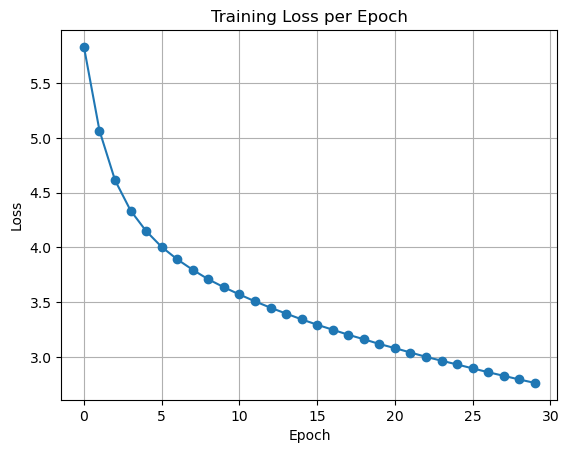

C:\Users\aamir\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(



BLEU Score: 0.88
ROUGE-1: 0.00
ROUGE-2: 0.00
ROUGE-L: 0.00

Model saved as 'transformer_translation_model.pth'


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sentencepiece as spm
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# 1. Load Tokenizers
tokenizer_en = spm.SentencePieceProcessor(model_file='bpe_en.model')
tokenizer_ur = spm.SentencePieceProcessor(model_file='bpe_ur.model')

# 2. Dataset
class TranslationDataset(Dataset):
    def __init__(self, src_lines, tgt_lines, src_tokenizer, tgt_tokenizer, max_len=128):
        self.src_lines = src_lines
        self.tgt_lines = tgt_lines
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.src_lines)

    def __getitem__(self, idx):
        src = [self.src_tokenizer.bos_id()] + self.src_tokenizer.encode(self.src_lines[idx], out_type=int) + [self.src_tokenizer.eos_id()]
        tgt = [self.tgt_tokenizer.bos_id()] + self.tgt_tokenizer.encode(self.tgt_lines[idx], out_type=int) + [self.tgt_tokenizer.eos_id()]
        
        src = src[:self.max_len]
        tgt = tgt[:self.max_len]

        src += [0] * (self.max_len - len(src))
        tgt += [0] * (self.max_len - len(tgt))
        
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

# 3. Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8, num_layers=4, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.src_tok_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, 5000, d_model), requires_grad=True)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt):
        src_emb = self.src_tok_emb(src) + self.positional_encoding[:, :src.size(1), :]
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding[:, :tgt.size(1), :]

        src_padding_mask = (src == 0)
        tgt_padding_mask = (tgt == 0)

        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(src.device)

        output = self.transformer(
            src_emb,
            tgt_emb,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=src_padding_mask,
            tgt_mask=tgt_mask
        )

        output = self.fc_out(output)
        return output

# 4. Data (assuming 'data' dictionary is loaded correctly)
train_src = data['quran']['train.en']
train_tgt = data['quran']['train.ur']
test_src = data['quran']['test.en']
test_tgt = data['quran']['test.ur']

train_dataset = TranslationDataset(train_src, train_tgt, tokenizer_en, tokenizer_ur)
test_dataset = TranslationDataset(test_src, test_tgt, tokenizer_en, tokenizer_ur)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 5. Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerModel(
    tokenizer_en.get_piece_size(),
    tokenizer_ur.get_piece_size()
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)

train_losses = []

# 6. Training loop
for epoch in range(30):
    model.train()
    running_loss = 0.0
    print(f"\nEpoch {epoch+1} Starting...")

    for batch_idx, (src, tgt) in enumerate(train_loader):
        src, tgt = src.to(device), tgt.to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.reshape(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f"Epoch {epoch+1} | Batch {batch_idx+1}/{len(train_loader)} | Batch Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Finished | Average Loss: {avg_loss:.4f}")

# 7. Visualize loss
plt.plot(train_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# 8. Evaluation (BLEU + ROUGE)
model.eval()
references = []
hypotheses = []

with torch.no_grad():
    for src, tgt in test_loader:
        src, tgt = src.to(device), tgt.to(device)

        tgt_input = tgt[:, :-1]

        output = model(src, tgt_input)
        output = output.argmax(dim=-1)

        for i in range(output.size(0)):
            pred_tokens = output[i].cpu().numpy().tolist()
            true_tokens = tgt[i, 1:].cpu().numpy().tolist()

            # Filter padding
            pred_tokens = [tok for tok in pred_tokens if tok != 0]
            true_tokens = [tok for tok in true_tokens if tok != 0]

            pred_sentence = tokenizer_ur.decode(pred_tokens)
            true_sentence = tokenizer_ur.decode(true_tokens)

            hypotheses.append(pred_sentence.split())
            references.append([true_sentence.split()])

# BLEU score
smoothie = SmoothingFunction().method4
bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
print(f"\nBLEU Score: {bleu_score*100:.2f}")

# ROUGE score
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1_list, rouge2_list, rougel_list = [], [], []

for ref, hyp in zip(references, hypotheses):
    ref_sent = ' '.join(ref[0])
    hyp_sent = ' '.join(hyp)
    scores = scorer.score(ref_sent, hyp_sent)

    rouge1_list.append(scores['rouge1'].fmeasure)
    rouge2_list.append(scores['rouge2'].fmeasure)
    rougel_list.append(scores['rougeL'].fmeasure)

print(f"ROUGE-1: {np.mean(rouge1_list)*100:.2f}")
print(f"ROUGE-2: {np.mean(rouge2_list)*100:.2f}")
print(f"ROUGE-L: {np.mean(rougel_list)*100:.2f}")

# 9. Save the model
torch.save(model.state_dict(), "transformer_translation_model.pth")
print("\nModel saved as 'transformer_translation_model.pth'")


LSTM

In [2]:
import os
import glob
import re
import sentencepiece as spm
import tensorflow as tf
import numpy as np

# Base data folder
base_path = 'C:\\Users\\aamir\\Downloads\\umc005-corpus'

# Quran and Bible subfolders
quran_folder = os.path.join(base_path, 'quran')
bible_folder = os.path.join(base_path, 'bible')

# Files to load
quran_files = ['Quran-EN', 'Quran-UR', 'Quran-UR-normalized', 'test.ur', 'test.en', 'train.ur', 'train.en', 'dev.ur', 'dev.en']
bible_files = ['Bible-EN', 'Bible-UR', 'Bible-EN-normalized', 'test.ur', 'test.en', 'train.ur', 'train.en', 'dev.ur', 'dev.en']

# Function to load text from files
def load_files(folder, filenames):
    data = {}
    for fname in filenames:
        full_path = os.path.join(folder, fname)
        if os.path.isfile(full_path):
            with open(full_path, encoding='utf-8') as f:
                data[fname] = f.read().splitlines()
    return data

# Load Quran and Bible data
quran_data = load_files(quran_folder, quran_files)
bible_data = load_files(bible_folder, bible_files)

# Merge relevant files (example: train.en and train.ur from both Quran and Bible)
train_en = quran_data.get('train.en', []) + bible_data.get('train.en', [])
train_ur = quran_data.get('train.ur', []) + bible_data.get('train.ur', [])

print(f"Loaded {len(train_en)} English training samples and {len(train_ur)} Urdu training samples.")

# Basic text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Zآ-ے0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_en = [clean_text(line) for line in train_en]
train_ur = [clean_text(line) for line in train_ur]

assert len(train_en) == len(train_ur), "Mismatch between English and Urdu lines!"


Loaded 13400 English training samples and 13400 Urdu training samples.


In [6]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Base data folder
base_path = 'C:\\Users\\aamir\\Downloads\\umc005-corpus'

# Quran and Bible subfolders
quran_folder = os.path.join(base_path, 'quran')
bible_folder = os.path.join(base_path, 'bible')

# Files to load
quran_files = ['Quran-EN', 'Quran-UR', 'Quran-UR-normalized', 'test.ur', 'test.en', 'train.ur', 'train.en', 'dev.ur', 'dev.en']
bible_files = ['Bible-EN', 'Bible-UR', 'Bible-EN-normalized', 'test.ur', 'test.en', 'train.ur', 'train.en', 'dev.ur', 'dev.en']

# Function to load text from files
def load_files(folder, filenames):
    data = {}
    for fname in filenames:
        full_path = os.path.join(folder, fname)
        if os.path.isfile(full_path):
            with open(full_path, encoding='utf-8') as f:
                data[fname] = f.read().splitlines()
    return data

# Load Quran and Bible data
quran_data = load_files(quran_folder, quran_files)
bible_data = load_files(bible_folder, bible_files)

# Merge relevant files (example: train.en and train.ur from both Quran and Bible)
train_en = quran_data.get('train.en', []) + bible_data.get('train.en', [])
train_ur = quran_data.get('train.ur', []) + bible_data.get('train.ur', [])

test_en = quran_data.get('test.en', []) + bible_data.get('test.en', [])
test_ur = quran_data.get('test.ur', []) + bible_data.get('test.ur', [])

print(f"Loaded {len(train_en)} English training samples and {len(train_ur)} Urdu training samples.")
print(f"Loaded {len(test_en)} English test samples and {len(test_ur)} Urdu test samples.")

# 1. Tokenizers
def en_tokenizer(text):
    return text.split()  # Simple whitespace-based tokenization for English

def ur_tokenizer(text):
    return text.split()  # Simple whitespace-based tokenization for Urdu

# 2. Build Vocabulary manually
def build_vocab(sentences, tokenizer, min_freq=2):
    counter = Counter()
    for sentence in sentences:
        tokens = tokenizer(sentence)
        counter.update(tokens)
    # Filter tokens by min_freq and add special tokens
    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    idx = 4
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

# 3. Encode Sentence
def encode_sentence(sentence, vocab, tokenizer, max_len=30):
    tokens = tokenizer(sentence)
    tokens = ['<sos>'] + tokens[:max_len-2] + ['<eos>']
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

# 4. Pad Sequences
def pad_sequence(seq, max_len, pad_idx):
    return seq + [pad_idx] * (max_len - len(seq))

# Prepare vocab
en_vocab = build_vocab(train_en, en_tokenizer)
ur_vocab = build_vocab(train_ur, ur_tokenizer)

# Add padding token index
pad_idx = ur_vocab["<pad>"]

# Dataset class
class TranslationDataset(Dataset):
    def __init__(self, src, tgt, src_vocab, tgt_vocab, src_tok, tgt_tok, max_len=30):
        self.src = src
        self.tgt = tgt
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.src_tok = src_tok
        self.tgt_tok = tgt_tok
        self.max_len = max_len
        self.pad_idx = tgt_vocab['<pad>']

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        # Encode source and target sentences
        src_seq = encode_sentence(self.src[idx], self.src_vocab, self.src_tok, self.max_len)
        tgt_seq = encode_sentence(self.tgt[idx], self.tgt_vocab, self.tgt_tok, self.max_len)
        # Pad sequences to ensure same length in a batch
        src_seq = pad_sequence(src_seq, self.max_len, self.src_vocab['<pad>'])
        tgt_seq = pad_sequence(tgt_seq, self.max_len, self.pad_idx)
        return torch.tensor(src_seq), torch.tensor(tgt_seq)

# Create the datasets
train_dataset = TranslationDataset(train_en, train_ur, en_vocab, ur_vocab, en_tokenizer, ur_tokenizer)
test_dataset = TranslationDataset(test_en, test_ur, en_vocab, ur_vocab, en_tokenizer, ur_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

print(f"Loaded {len(train_en)} English training samples and {len(train_ur)} Urdu training samples.")
print(f"Loaded {len(test_en)} English test samples and {len(test_ur)} Urdu test samples.")


Loaded 13400 English training samples and 13400 Urdu training samples.
Loaded 457 English test samples and 457 Urdu test samples.
Loaded 13400 English training samples and 13400 Urdu training samples.
Loaded 457 English test samples and 457 Urdu test samples.


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Encoder with Dropout
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

# Decoder with Dropout
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedded = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        predictions = self.fc(outputs.squeeze(1))
        return predictions, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size, tgt_len = tgt.shape
        outputs = torch.zeros(batch_size, tgt_len, self.decoder.fc.out_features).to(DEVICE)
        hidden, cell = self.encoder(src)
        input = tgt[:, 0]

        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = tgt[:, t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs


Epoch 1, Step 10/210, Loss: 7.4192
Epoch 1, Step 20/210, Loss: 6.4645
Epoch 1, Step 30/210, Loss: 6.2476
Epoch 1, Step 40/210, Loss: 6.3129
Epoch 1, Step 50/210, Loss: 6.2007
Epoch 1, Step 60/210, Loss: 6.0758
Epoch 1, Step 70/210, Loss: 6.2062
Epoch 1, Step 80/210, Loss: 6.1899
Epoch 1, Step 90/210, Loss: 6.1429
Epoch 1, Step 100/210, Loss: 6.0560
Epoch 1, Step 110/210, Loss: 6.1122
Epoch 1, Step 120/210, Loss: 6.0801
Epoch 1, Step 130/210, Loss: 6.0714
Epoch 1, Step 140/210, Loss: 6.0444
Epoch 1, Step 150/210, Loss: 6.0051
Epoch 1, Step 160/210, Loss: 6.0948
Epoch 1, Step 170/210, Loss: 6.0094
Epoch 1, Step 180/210, Loss: 6.1192
Epoch 1, Step 190/210, Loss: 6.0260
Epoch 1, Step 200/210, Loss: 6.0642
Epoch 1, Step 210/210, Loss: 6.0246

Epoch 1
Train Loss: 6.2508
BLEU: 0.9661, ROUGE-1 -> Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Model saved.
Epoch 2, Step 10/210, Loss: 6.0382
Epoch 2, Step 20/210, Loss: 5.9462
Epoch 2, Step 30/210, Loss: 5.9942
Epoch 2, Step 40/210, Loss: 6.0528
E

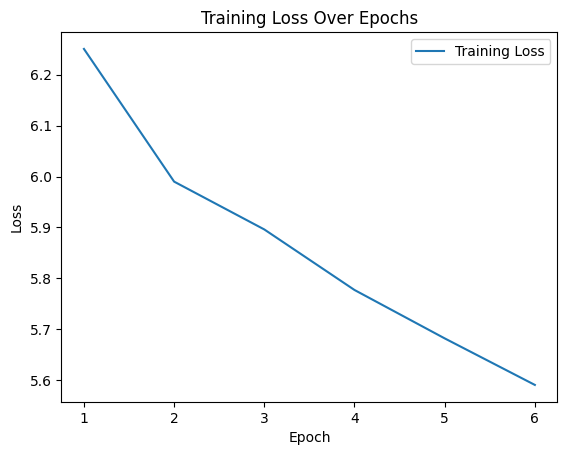

In [ ]:

# Hyperparameters
embedding_dim = 256
hidden_dim = 512
num_layers = 2
dropout = 0.3
learning_rate = 5e-4
epochs = 20
clip = 1.0

# Instantiate model
encoder = Encoder(len(en_vocab), embedding_dim, hidden_dim, num_layers, dropout).to(DEVICE)
decoder = Decoder(len(ur_vocab), embedding_dim, hidden_dim, num_layers, dropout).to(DEVICE)
model = Seq2Seq(encoder, decoder).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=ur_vocab['<pad>'])


# Evaluation
def evaluate(model, data_loader, tgt_vocab):
    model.eval()
    predictions, references = [], []
    rouge = Rouge()
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            output = model(src, tgt[:, :-1])
            for i in range(src.size(0)):
                pred_tokens = output[i].argmax(1).cpu().numpy()
                pred_sentence = [tgt_vocab.get(word, '<unk>') for word in pred_tokens]
                pred_sentence = ' '.join(pred_sentence).replace('<eos>', '').strip()
                ref_sentence = [tgt_vocab.get(word, '<unk>') for word in tgt[i].cpu().numpy()]
                ref_sentence = ' '.join(ref_sentence).replace('<eos>', '').strip()
                predictions.append(pred_sentence.split())
                references.append([ref_sentence.split()])

    bleu_score = np.mean([sentence_bleu(ref, pred) for ref, pred in zip(references, predictions)])
    rouge_score = rouge.get_scores([' '.join(pred) for pred in predictions],
                                   [' '.join(ref[0]) for ref in references], avg=True)
    return bleu_score, rouge_score['rouge-1']['p'], rouge_score['rouge-1']['r'], rouge_score['rouge-1']['f']

# Training loop
train_losses = []
best_bleu = 0
patience = 5
no_improve = 0

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (src, tgt) in enumerate(train_loader):
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])

        output = output.contiguous().view(-1, output.shape[-1])
        tgt = tgt[:, 1:].contiguous().view(-1)
        loss = criterion(output, tgt)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Step {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    bleu, rouge_p, rouge_r, rouge_f = evaluate(model, test_loader, ur_vocab)
    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {avg_loss:.4f}")
    print(f"BLEU: {bleu:.4f}, ROUGE-1 -> Precision: {rouge_p:.4f}, Recall: {rouge_r:.4f}, F1: {rouge_f:.4f}")

    if bleu > best_bleu:
        best_bleu = bleu
        no_improve = 0
        torch.save(model.state_dict(), "best_lstm_model.pth")
        print("Model saved.")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break

# Plot
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()